# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

- UPDATE: I'm using the AVE split now

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import sys
# sys.path.append('..')
sys.path.insert(0, "/g/g13/jones289/workspace/hd-cuda-master")
# print(sys.path)
import hdpy
import hdpy.ecfp
# from hdpy.analysis import load_pkl
from hdpy.metrics import compute_enrichment_factor
from pathlib import Path


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


# SEED=125
SEED=5
# SEED=6
# SEED=7
# SEED=8
# SEED=2

#TODO: rename to result_p 
data_p = Path(f"/p/vast1/jones289/hd_results/{SEED}")

lit_pcba_full_data_p = Path(f"/p/vast1/jones289/lit_pcba/lit_pcba_full_data")

In [2]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [3]:
model_dict = {
    "molehd-bpe": ("MoleHD-BPE", rocket_color_pal[4]),
    "hdbind-rp-molformer": ("HDBind+MolFormer-10k", green_color_pal[6]),
    "hdbind-rp-molformer-100k": ("HDBind+MolFormer-100k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-100": ("HDBind+ECFP-100", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-1k": ("HDBind+ECFP-1k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1": ("HDBind+ECFP-10k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-100k": ("HDBind+ECFP-100k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-1m": ("HDBind+ECFP-1m", green_color_pal[6]),    
    "mlp-1024-1": ("MLP", blue_color_pal[7]),
    "Vina": ("Vina", "salmon"),
}

# LIT-PCBA Results

export CONDA_ROOT=/usr/workspace/jones289/anaconda3-power #installed using the LC installer script
export PATH=$CONDA_ROOT/bin:$PATH
export CONDA_EXE=$CONDA_ROOT/bin/conda
ml load gcc/11
export PYTHONPATH=$PWD:$PYTHONPATH
source activate /usr/workspace/jones289/anaconda3-power/envs/opence-1.8.0

In [4]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score


def compute_metrics(y_pred, y_score, y_true, p):
#     import pdb
#     pdb.set_trace()


    if y_score.squeeze().ndim == 2:
        enrich = float(compute_enrichment_factor(scores=y_score[:, 1], labels=y_true, n_percent=p))
        roc = roc_auc_score(y_score=y_score[:, 1], y_true=y_true)
    else:
        enrich = float(compute_enrichment_factor(scores=y_score, labels=y_true, n_percent=p))
        roc = roc_auc_score(y_score=y_score, y_true=y_true)

    
    
    return {"precision": precision_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "recall": recall_score(y_pred=y_pred, y_true=y_true),
           "f1": f1_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "enrich": enrich,            
           "roc": roc
           }


def aggregate_results(dataset, split, target_list=None):
    assert target_list is not None
#     import pdb
#     pdb.set_trace() 
    
#     if split == "random":
#         raise NotImplementedError # rename the files with "-random" to be consistent
        
    
    model_metric_dict = {"model": [], "enrich": [], "p":[], "train_time":[], "test_time": [], "target": [],
                        "seed": [], "recall": [], "precision": [], "f1": [], 
#                          "smiles": []
                        }


    for model_name, model_tup in tqdm(model_dict.items(), total=len(model_dict), position=0):
                        

        data_path_list = list(data_p.glob(f"{model_name}.{dataset}-*-{split}*.pkl"))
#         print(f"{model_name}\t{dataset}\t{len(model_tup)}\t {len(data_path_list)}")

        
        for path in tqdm(data_path_list, total=len(data_path_list), position=1):
            target = path.name.split(".")[1].split("-")[-2]
            print(target, path, model_name)

            if target in target_list or target_list == "all":
                pass
            else:
                continue
            
            model_data_dict = torch.load(path)
            
            # apparently we have duplicates in the test set...
            

            for seed in range(len(model_data_dict['trials'])):

    
                
                trial_dict = model_data_dict['trials'][seed]
            
            

                for p in [.01, .1]:

                    try:

                        
                        y_pred = trial_dict["y_pred"]
                        y_score = trial_dict["eta"]
                        
                        if model_name == "mlp":
                            y_score = y_score[:, 1]
                        
                        
#                         y_true = model_data_dict["y_test"]
                        y_true = trial_dict["y_true"]


                        # TODO: there are some issues with the number of smiles not lining up with the number of predictions/etc...
#                         import pdb
#                         pdb.set_trace()
                        print(f"y_pred: {y_pred.shape}\ty_score: {y_score.shape}\ty_true: {y_true.shape}")

                        
                        
                        metrics = compute_metrics(y_pred=y_pred, 
                                                  y_score=y_score, 
                                                  y_true=y_true,
                                                 p=p)

                        
                        
                        
                        
                        
                        
                        model_metric_dict["target"].append(target)
                        model_metric_dict["test_time"].append(trial_dict["test_time"])
                        model_metric_dict["enrich"].append(metrics["enrich"])
                        model_metric_dict["p"].append(p)
                        model_metric_dict["seed"].append(seed)
                        model_metric_dict["precision"].append(metrics["precision"])
                        model_metric_dict["recall"].append(metrics["recall"])
                        model_metric_dict["f1"].append(metrics["f1"])
                        model_metric_dict["model"].append(model_name)
#                         model_metric_dict["smiles"].append(model_data_dict["smiles_test"])
                        
                    except Exception as e:
                        print(e)


    model_metric_df = pd.DataFrame({key: value for key, value in model_metric_dict.items() if key not in ["train_time", "test_time", "precision", "recall", "f1"]})

#     import pdb
#     pdb.set_trace()
    return model_metric_df
        


# VINA result

In [5]:
from pathlib import Path

def load_lit_pcba_vina(nrows=None, split=None, target_list=None):

    
#     assert target_list is not None
    assert split is not None



    root_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/")
    lig_map_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/lig_rec/")
#     /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/lig_rec/ # this path stores the map between conveyor and the original files
    
    path_list = [path for path in root_p.glob("*-actives.csv")]
#     print(len(path_list))

    df_list = []

    for idx, path in tqdm(enumerate(path_list), total=len(path_list)):
        
#         import pdb
#         pdb.set_trace()
        target = path.name.split(".")[0].split("-")[0]
#         print(target, target_list, (target in target_list))
        if target in target_list or target_list == "all":

        
            active_lig_map = pd.read_csv(lig_map_p / f"lig-{target}-actives.csv")
            inactive_lig_map = pd.read_csv(lig_map_p / f"lig-{target}-inactives.csv")

            lig_map = pd.concat([active_lig_map, inactive_lig_map])

            
#             import pdb
#             pdb.set_trace()
            active_smiles_df = pd.read_csv(f"{lit_pcba_full_data_p}/{target}/actives.smi", delim_whitespace=True, header=None)
            inactive_smiles_df = pd.read_csv(f"{lit_pcba_full_data_p}/{target}/inactives.smi", delim_whitespace=True, header=None)
            smiles_df = pd.concat([active_smiles_df, inactive_smiles_df])

            input_num_mols = smiles_df.shape[0]


            # Filter out the test set smiles strings

            test_smiles_path = f"/p/vast1/jones289/hd_results/{SEED}/hdbind-rp-molformer.lit-pcba-{target}-{split}.{SEED}.pkl"         
            print(test_smiles_path)
            test_smiles = torch.load(test_smiles_path)["smiles_test"]

#             import pdb
#             pdb.set_trace()

            # TODO: there's missing docking data?
            smiles_df = pd.merge(smiles_df, pd.DataFrame({0: test_smiles}), on=0)

            smiles_df = smiles_df.drop_duplicates(subset=[0])

            print(f"started with {input_num_mols} molecules for {target}, after merging with available docking data, have {smiles_df.shape[0]}/{len(test_smiles)} in test set")



    #         smiles_df = smiles_df[smiles_df[1].apply(lambda x: x in test_smiles.values)]





            target_df = pd.merge(lig_map, smiles_df, left_on=" name", right_on=1)

            # dock_score_cols = {idx: value for idx,value in enumerate(["file", "key", "Mesg", "Box/cx", "Box/cy", "Box/cz", "Box/dx", "Box/dy", "Box/dz", 
                        #    "ligName", 
                        #    "numPose", 
                        #    "scores/1", 
                        #    "scores/2", 
                        #    "scores/3", 
                        #    "scores/4", 
                        #    "scores/5", 
                        #    "scores/6", 
                        #    "scores/7", 
                        #    "scores/8", 
                        #    "scores/9", 
                        #    "scores/10", 
                        #    "Box/default"])}
            lig_id_col = 9
            active_dock_scores = pd.read_csv(root_p / Path(f"{target}-actives.csv.clean"), header=None)
            active_dock_scores["label"] = [1] * len(active_dock_scores)

            inactive_dock_scores = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), header=None)
            inactive_dock_scores["label"] = [0] * len(inactive_dock_scores)
            dock_scores = pd.concat([active_dock_scores, inactive_dock_scores])


            dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)


            dock_scores = dock_scores.groupby(lig_id_col)[[lig_id_col, 'min_vina', 'label']].min().reset_index(drop=True)


            target_df = pd.merge(dock_scores, target_df, left_on=9, right_on=" name")

            target_df["target"] = [target] * len(target_df)

            # compute enrichment at 1% and 10%




    #         import pdb
    #         pdb.set_trace() 

            df_list.append(target_df)
        else:
            pass


    df = pd.concat(df_list)
    return df


In [6]:

def make_box_plot(enrich_1_df, enrich_10_df, dataset:str, split:str):
    
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
    
    enrich_f.suptitle(f"{dataset.upper()} ({split})")
    
    
    sns.swarmplot(data=enrich_1_df, x="model", y="enrich", 
                  order=list(model_dict.keys()),
                  palette={key: value[1] for key, value in model_dict.items()},
                  ax=enrich_1_ax)
    enrich_1_ax.set_title(f"Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

        
    sns.swarmplot(data=enrich_10_df, x="model", y="enrich",
                  order=list(model_dict.keys()),
                  palette={key: value[1] for key, value in model_dict.items()},
                  ax=enrich_10_ax)

    enrich_10_ax.set_title(f"Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [model_dict[item.get_text()][0] for item in enrich_10_ax.get_xticklabels()]

    enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()

    enrich_f.savefig(f"{dataset}-{split}-enrich.png", dpi=600, bbox_inches="tight")





def compute_model_metric_df(dataset, split, target_list=None):
    
    assert target_list is not None
    
    docking_df = load_lit_pcba_vina(target_list=target_list, split=split)

    
    model_metric_df = aggregate_results(dataset=dataset,
                                        split=split, target_list=target_list)
    

    docking_dict = {"enrich": [], "p": [], "model": [], "target": []}

    vina_col='min_vina'
    label_col = "label"
    for target, target_df in docking_df.groupby("target"):

        for p in [.1, .01]:
            enrich = compute_enrichment_factor(scores=np.abs(target_df[vina_col]), 
                                      labels=target_df[label_col], 
                                      n_percent=p)

            docking_dict["enrich"].append(float(enrich))
            docking_dict["p"].append(p)
            docking_dict["model"].append("Vina")
            docking_dict["target"].append(target)
           
    model_metric_df = pd.concat([model_metric_df, pd.DataFrame(docking_dict)])
    
    
    # take the average over the random seeds dimension for each combo of MODEL X TARGET X P
    grp_df = (model_metric_df).groupby(["model", "target", "p"])["enrich"].mean().reset_index()
    grp_df = grp_df.sort_values(by="model")
    
    
    for name, group in grp_df.groupby(["model", "p"]):
        print(name)
        print(group.describe())


    make_box_plot(enrich_1_df=grp_df[grp_df["p"] == .01], 
          enrich_10_df=grp_df[grp_df["p"] == .1],
             dataset=dataset, split=split)

    return model_metric_df


  0%|          | 0/15 [00:00<?, ?it/s]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PKM2-ave.5.pkl
started with 246069 molecules for PKM2, after merging with available docking data, have 43472/61516 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
  7%|▋         | 1/15 [00:17<04:00, 17.20s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-GBA-ave.5.pkl
started with 296218 molecules for GBA, after merging with available docking data, have 51872/74054 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 13%|█▎        | 2/15 [00:31<03:23, 15.62s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ago-ave.5.pkl
started with 5596 molecules for ESR1_ago, after merging with available docking data, have 971/1398 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 20%|██        | 3/15 [00:32<01:47,  8.95s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MAPK1-ave.5.pkl
started with 62937 molecules for MAPK1, after merging with available docking data, have 10778/15734 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 27%|██▋       | 4/15 [00:39<01:28,  8.05s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-VDR-ave.5.pkl
started with 356272 molecules for VDR, after merging with available docking data, have 47296/66800 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 33%|███▎      | 5/15 [00:46<01:16,  7.68s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-KAT2A-ave.5.pkl
started with 348742 molecules for KAT2A, after merging with available docking data, have 61847/87185 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 40%|████      | 6/15 [00:55<01:14,  8.29s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ALDH1-ave.5.pkl
started with 145133 molecules for ALDH1, after merging with available docking data, have 19303/27212 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 47%|████▋     | 7/15 [01:04<01:08,  8.51s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-TP53-ave.5.pkl
started with 4247 molecules for TP53, after merging with available docking data, have 744/1061 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 53%|█████▎    | 8/15 [01:05<00:41,  5.94s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PPARG-ave.5.pkl
started with 5238 molecules for PPARG, after merging with available docking data, have 958/1308 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 60%|██████    | 9/15 [01:06<00:25,  4.33s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ADRB2-ave.5.pkl
started with 312500 molecules for ADRB2, after merging with available docking data, have 55031/78124 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 67%|██████▋   | 10/15 [01:25<00:44,  8.84s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MTORC1-ave.5.pkl
started with 33069 molecules for MTORC1, after merging with available docking data, have 6385/8267 in test set


/tmp/ipykernel_4138038/2535884398.py:88: DtypeWarning: Columns (12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  inactive_dock_scores = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), header=None)
/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 73%|███████▎  | 11/15 [01:28<00:28,  7.07s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-OPRK1-ave.5.pkl
started with 269840 molecules for OPRK1, after merging with available docking data, have 47848/67460 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 80%|████████  | 12/15 [01:31<00:18,  6.08s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-IDH1-ave.5.pkl
started with 362088 molecules for IDH1, after merging with available docking data, have 64232/90521 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 87%|████████▋ | 13/15 [02:08<00:30, 15.41s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ant-ave.5.pkl
started with 5050 molecules for ESR1_ant, after merging with available docking data, have 895/1262 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 93%|█████████▎| 14/15 [02:09<00:11, 11.06s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-FEN1-ave.5.pkl
started with 355771 molecules for FEN1, after merging with available docking data, have 62823/88942 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ADRB2-ave.5.pkl molehd-bpe
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true:


  7%|▋         | 1/15 [00:21<04:55, 21.11s/it]

ALDH1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ALDH1-ave.5.pkl molehd-bpe
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true:


 13%|█▎        | 2/15 [00:27<02:43, 12.57s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ago-ave.5.pkl molehd-bpe
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)



 20%|██        | 3/15 [00:28<01:23,  6.99s/it]

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ant-ave.5.pkl molehd-bpe
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (12


 27%|██▋       | 4/15 [00:28<00:47,  4.36s/it]

y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
FEN1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-FEN1-ave.5.pkl molehd-bpe
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942,


 33%|███▎      | 5/15 [00:52<01:53, 11.37s/it]

GBA /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-GBA-ave.5.pkl molehd-bpe
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74


 40%|████      | 6/15 [01:12<02:08, 14.30s/it]

IDH1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-IDH1-ave.5.pkl molehd-bpe
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (


 47%|████▋     | 7/15 [01:36<02:21, 17.70s/it]

KAT2A /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-KAT2A-ave.5.pkl molehd-bpe
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true:


 53%|█████▎    | 8/15 [02:00<02:17, 19.65s/it]

MAPK1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MAPK1-ave.5.pkl molehd-bpe
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true:


 60%|██████    | 9/15 [02:04<01:27, 14.62s/it]

y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
MTORC1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MTORC1-ave.5.pkl molehd-bpe
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (826


 67%|██████▋   | 10/15 [02:06<00:53, 10.67s/it]

OPRK1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-OPRK1-ave.5.pkl molehd-bpe
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true:


 73%|███████▎  | 11/15 [02:23<00:51, 12.82s/it]

PKM2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PKM2-ave.5.pkl molehd-bpe
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (


 80%|████████  | 12/15 [02:40<00:41, 13.94s/it]

PPARG /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PPARG-ave.5.pkl molehd-bpe
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)



 87%|████████▋ | 13/15 [02:40<00:19,  9.83s/it]

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-TP53-ave.5.pkl molehd-bpe
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y


 93%|█████████▎| 14/15 [02:40<00:06,  6.95s/it]

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-VDR-ave.5.pkl molehd-bpe
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-molformer
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: 


  7%|▋         | 1/15 [00:21<04:54, 21.04s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-molformer
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: 


 13%|█▎        | 2/15 [00:27<02:42, 12.53s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-molformer
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)



 20%|██        | 3/15 [00:27<01:23,  6.96s/it]

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-molformer
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (126


 27%|██▋       | 4/15 [00:28<00:47,  4.33s/it]

FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-FEN1-ave.5.pkl hdbind-rp-molformer
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (8


 33%|███▎      | 5/15 [00:52<01:54, 11.46s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-GBA-ave.5.pkl hdbind-rp-molformer
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (740


 40%|████      | 6/15 [01:12<02:08, 14.33s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-IDH1-ave.5.pkl hdbind-rp-molformer
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (9


 47%|████▋     | 7/15 [01:36<02:20, 17.58s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-molformer
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: 


 53%|█████▎    | 8/15 [02:00<02:17, 19.59s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-molformer
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: 


 60%|██████    | 9/15 [02:03<01:27, 14.58s/it]

y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-molformer
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267


 67%|██████▋   | 10/15 [02:05<00:53, 10.62s/it]

OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-molformer
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: 


 73%|███████▎  | 11/15 [02:23<00:51, 12.81s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PKM2-ave.5.pkl hdbind-rp-molformer
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (6


 80%|████████  | 12/15 [02:39<00:41, 13.82s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PPARG-ave.5.pkl hdbind-rp-molformer
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)



 87%|████████▋ | 13/15 [02:39<00:19,  9.73s/it]

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-TP53-ave.5.pkl hdbind-rp-molformer
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)



 93%|█████████▎| 14/15 [02:40<00:06,  6.87s/it]

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-VDR-ave.5.pkl hdbind-rp-molformer
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)


  7%|▋         | 1/15 [00:21<04:55, 21.14s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)


 13%|█▎        | 2/15 [00:27<02:44, 12.63s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_


 20%|██        | 3/15 [00:28<01:25,  7.08s/it]

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_


 27%|██▋       | 4/15 [00:28<00:49,  4.47s/it]

y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-FEN1-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942,


 33%|███▎      | 5/15 [00:53<01:58, 11.81s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-GBA-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_s


 40%|████      | 6/15 [01:13<02:11, 14.64s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-IDH1-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y


 47%|████▋     | 7/15 [01:38<02:23, 17.95s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)


 53%|█████▎    | 8/15 [02:02<02:19, 19.88s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)


 60%|██████    | 9/15 [02:06<01:29, 14.83s/it]

MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred


 67%|██████▋   | 10/15 [02:08<00:54, 10.84s/it]

y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score:


 73%|███████▎  | 11/15 [02:26<00:52, 13.05s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-PKM2-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y


 80%|████████  | 12/15 [02:42<00:42, 14.04s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-PPARG-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)



 87%|████████▋ | 13/15 [02:42<00:19,  9.94s/it]

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-TP53-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1


 93%|█████████▎| 14/15 [02:43<00:07,  7.06s/it]

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-VDR-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 


  7%|▋         | 1/15 [00:21<04:57, 21.27s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 


 13%|█▎        | 2/15 [00:27<02:44, 12.64s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)



 20%|██        | 3/15 [00:28<01:24,  7.02s/it]

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)



 27%|██▋       | 4/15 [00:28<00:48,  4.37s/it]

FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-FEN1-ave.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)


 33%|███▎      | 5/15 [00:52<01:54, 11.45s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-GBA-ave.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y


 40%|████      | 6/15 [01:12<02:09, 14.35s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-IDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)


 47%|████▋     | 7/15 [01:36<02:21, 17.66s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 


 53%|█████▎    | 8/15 [02:00<02:17, 19.65s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 


 60%|██████    | 9/15 [02:04<01:27, 14.64s/it]

y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y


 67%|██████▋   | 10/15 [02:06<00:53, 10.67s/it]

y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_s


 73%|███████▎  | 11/15 [02:24<00:51, 12.84s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-PKM2-ave.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)


 80%|████████  | 12/15 [02:40<00:41, 13.84s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-PPARG-ave.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)



 87%|████████▋ | 13/15 [02:40<00:19,  9.75s/it]

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-TP53-ave.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)



 93%|█████████▎| 14/15 [02:40<00:06,  6.88s/it]

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-VDR-ave.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)


  7%|▋         | 1/15 [00:21<04:55, 21.12s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)


 13%|█▎        | 2/15 [00:27<02:43, 12.55s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)



 20%|██        | 3/15 [00:28<01:23,  6.97s/it]

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_


 27%|██▋       | 4/15 [00:28<00:47,  4.34s/it]

FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-FEN1-ave.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y


 33%|███▎      | 5/15 [00:52<01:55, 11.50s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-GBA-ave.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_s


 40%|████      | 6/15 [01:12<02:09, 14.42s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-IDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y


 47%|████▋     | 7/15 [01:37<02:22, 17.78s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)


 53%|█████▎    | 8/15 [02:01<02:18, 19.72s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)


 60%|██████    | 9/15 [02:04<01:28, 14.67s/it]

y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_p


 67%|██████▋   | 10/15 [02:06<00:53, 10.69s/it]

y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_sco


 73%|███████▎  | 11/15 [02:24<00:51, 12.88s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-PKM2-ave.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y


 80%|████████  | 12/15 [02:40<00:41, 13.88s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-PPARG-ave.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)



 87%|████████▋ | 13/15 [02:40<00:19,  9.77s/it]

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-TP53-ave.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)



 93%|█████████▎| 14/15 [02:41<00:06,  6.90s/it]

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-VDR-ave.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_sco


  7%|▋         | 1/15 [00:21<04:58, 21.30s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_sco


 13%|█▎        | 2/15 [00:27<02:45, 12.70s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)



 20%|██        | 3/15 [00:28<01:24,  7.06s/it]

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: 


 27%|██▋       | 4/15 [00:28<00:48,  4.40s/it]

y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-FEN1-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942,


 33%|███▎      | 5/15 [00:53<01:56, 11.66s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-GBA-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: 


 40%|████      | 6/15 [01:13<02:11, 14.64s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-IDH1-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score


 47%|████▋     | 7/15 [01:38<02:24, 18.05s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_sco


 53%|█████▎    | 8/15 [02:03<02:20, 20.07s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_sco


 60%|██████    | 9/15 [02:06<01:29, 14.95s/it]

y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (


 67%|██████▋   | 10/15 [02:08<00:54, 10.90s/it]

y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score:


 73%|███████▎  | 11/15 [02:27<00:52, 13.21s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PKM2-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score


 80%|████████  | 12/15 [02:43<00:42, 14.27s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PPARG-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)



 87%|████████▋ | 13/15 [02:44<00:20, 10.05s/it]

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-TP53-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1


 93%|█████████▎| 14/15 [02:44<00:07,  7.10s/it]

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-VDR-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124


  7%|▋         | 1/15 [00:21<04:59, 21.39s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212


 13%|█▎        | 2/15 [00:28<02:48, 12.94s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1


 20%|██        | 3/15 [00:28<01:27,  7.25s/it]

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)



 27%|██▋       | 4/15 [00:29<00:50,  4.59s/it]

y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-FEN1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_tr


 33%|███▎      | 5/15 [00:53<01:57, 11.79s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-GBA-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)


 40%|████      | 6/15 [01:14<02:12, 14.74s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-IDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 


 47%|████▋     | 7/15 [01:39<02:23, 17.98s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185


 53%|█████▎    | 8/15 [02:03<02:19, 19.99s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734


 60%|██████    | 9/15 [02:07<01:29, 14.91s/it]

MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_


 67%|██████▋   | 10/15 [02:09<00:54, 10.92s/it]

OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460


 73%|███████▎  | 11/15 [02:27<00:52, 13.16s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-PKM2-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 


 80%|████████  | 12/15 [02:44<00:42, 14.24s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-PPARG-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pr


 87%|████████▋ | 13/15 [02:44<00:20, 10.06s/it]

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-TP53-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred


 93%|█████████▎| 14/15 [02:44<00:07,  7.14s/it]

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-VDR-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)


  7%|▋         | 1/15 [00:23<05:22, 23.04s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)


 13%|█▎        | 2/15 [00:31<03:09, 14.58s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)



 20%|██        | 3/15 [00:33<01:45,  8.80s/it]

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_


 27%|██▋       | 4/15 [00:35<01:06,  6.07s/it]

y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-FEN1-ave.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942,


 33%|███▎      | 5/15 [01:01<02:13, 13.35s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-GBA-ave.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_s


 40%|████      | 6/15 [01:23<02:26, 16.27s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-IDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y


 47%|████▋     | 7/15 [01:50<02:36, 19.62s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)


 53%|█████▎    | 8/15 [02:16<02:31, 21.66s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)


 60%|██████    | 9/15 [02:21<01:39, 16.53s/it]

MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred


 67%|██████▋   | 10/15 [02:24<01:02, 12.46s/it]

y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_sco


 73%|███████▎  | 11/15 [02:44<00:59, 14.75s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-PKM2-ave.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y


 80%|████████  | 12/15 [03:02<00:47, 15.77s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-PPARG-ave.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)


 87%|████████▋ | 13/15 [03:04<00:23, 11.56s/it]


y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-TP53-ave.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (


 93%|█████████▎| 14/15 [03:06<00:08,  8.63s/it]

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-VDR-ave.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ADRB2-ave.5.pkl mlp-1024-1
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score:


  7%|▋         | 1/15 [01:39<23:09, 99.22s/it]

ALDH1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ALDH1-ave.5.pkl mlp-1024-1
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score:


 13%|█▎        | 2/15 [02:09<12:43, 58.75s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ago-ave.5.pkl mlp-1024-1
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_


 20%|██        | 3/15 [02:10<06:29, 32.45s/it]

y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
ESR1_ant /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ant-ave.5.pkl mlp-1024-1
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_


 27%|██▋       | 4/15 [02:11<03:39, 19.98s/it]

y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
FEN1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-FEN1-ave.5.pkl mlp-1024-1
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.S


 33%|███▎      | 5/15 [04:07<09:06, 54.63s/it]

GBA /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-GBA-ave.5.pkl mlp-1024-1
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: tor


 40%|████      | 6/15 [05:43<10:16, 68.53s/it]

IDH1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-IDH1-ave.5.pkl mlp-1024-1
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: t


 47%|████▋     | 7/15 [07:38<11:10, 83.84s/it]

KAT2A /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-KAT2A-ave.5.pkl mlp-1024-1
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score:


 53%|█████▎    | 8/15 [09:28<10:44, 92.13s/it]

MAPK1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MAPK1-ave.5.pkl mlp-1024-1
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score:


 60%|██████    | 9/15 [09:44<06:49, 68.33s/it]

MTORC1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MTORC1-ave.5.pkl mlp-1024-1
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true


 67%|██████▋   | 10/15 [09:52<04:08, 49.61s/it]

OPRK1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-OPRK1-ave.5.pkl mlp-1024-1
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score:


 73%|███████▎  | 11/15 [11:12<03:56, 59.15s/it]

PKM2 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PKM2-ave.5.pkl mlp-1024-1
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: t


 80%|████████  | 12/15 [12:28<03:12, 64.05s/it]

PPARG /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PPARG-ave.5.pkl mlp-1024-1
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])



 87%|████████▋ | 13/15 [12:28<01:29, 44.76s/it]

y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
TP53 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-TP53-ave.5.pkl mlp-1024-1
y_pred: torch.Size([1061])	y_score: torch.Size([1061, 2])	y_true: to


 93%|█████████▎| 14/15 [12:29<00:31, 31.48s/it]

y_pred: torch.Size([1061])	y_score: torch.Size([1061, 2])	y_true: torch.Size([1061])
VDR /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-VDR-ave.5.pkl mlp-1024-1
y_pred: torch.Size([66800])	y_score: torch.Size([66800, 2])	y_true: torch.Size([66800])
y_pred: torch.Size([66800])	y_score: torch.Size([66800, 2])	y_true: torch.Size([66800])
y_pred: torch.Size([66800])	y_score: torch.Size([66800, 2])	y_true: torch.Size([66800])
y_pred: torch.Size([66800])	y_score: torch.Size([66800, 2])	y_true: torch.Size([66800])
y_pred: torch.Size([66800])	y_score: torch.Size([66800, 2])	y_true: torch.Size([66800])
y_pred: torch.Size([66800])	y_score: torch.Size([66800, 2])	y_true: torch.Size([66800])
y_pred: torch.Size([66800])	y_score: torch.Size([66800, 2])	y_true: torch.Size([66800])
y_pred: torch.Size([66800])	y_score: torch.Size([66800, 2])	y_true: torch.Size([66800])
y_pred: torch.Size([66800])	y_score: torch.Size([66800, 2])	y_true: torch.Size([66800])
y_pred: torch.Size([66800])	y_score: torch.


 90%|█████████ | 9/10 [38:20<06:30, 390.68s/it]
0it [00:00, ?it/s]
100%|██████████| 10/10 [38:20<00:00, 230.10s/it]


('Vina', 0.01)
           p     enrich
count  15.00  15.000000
mean    0.01   0.626063
std     0.00   0.932153
min     0.01   0.000000
25%     0.01   0.000000
50%     0.01   0.000000
75%     0.01   1.185305
max     0.01   3.122324
('Vina', 0.1)
                  p     enrich
count  1.500000e+01  15.000000
mean   1.000000e-01   1.382682
std    2.872975e-17   0.958248
min    1.000000e-01   0.000000
25%    1.000000e-01   0.917282
50%    1.000000e-01   1.304161
75%    1.000000e-01   1.651117
max    1.000000e-01   3.332918
('hdbind-rp-ecfp-1024-1', 0.01)
           p     enrich
count  15.00  15.000000
mean    0.01   5.351097
std     0.00   6.582956
min     0.01   0.000000
25%     0.01   1.692604
50%     0.01   3.553589
75%     0.01   5.517831
max     0.01  25.200957
('hdbind-rp-ecfp-1024-1', 0.1)
                  p     enrich
count  1.500000e+01  15.000000
mean   1.000000e-01   2.857164
std    2.872975e-17   1.735331
min    1.000000e-01   0.166667
25%    1.000000e-01   1.801959
50%    1.00

/usr/workspace/wsa/jones289/miniconda3/envs/dtra_reactivator/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/workspace/wsa/jones289/miniconda3/envs/dtra_reactivator/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


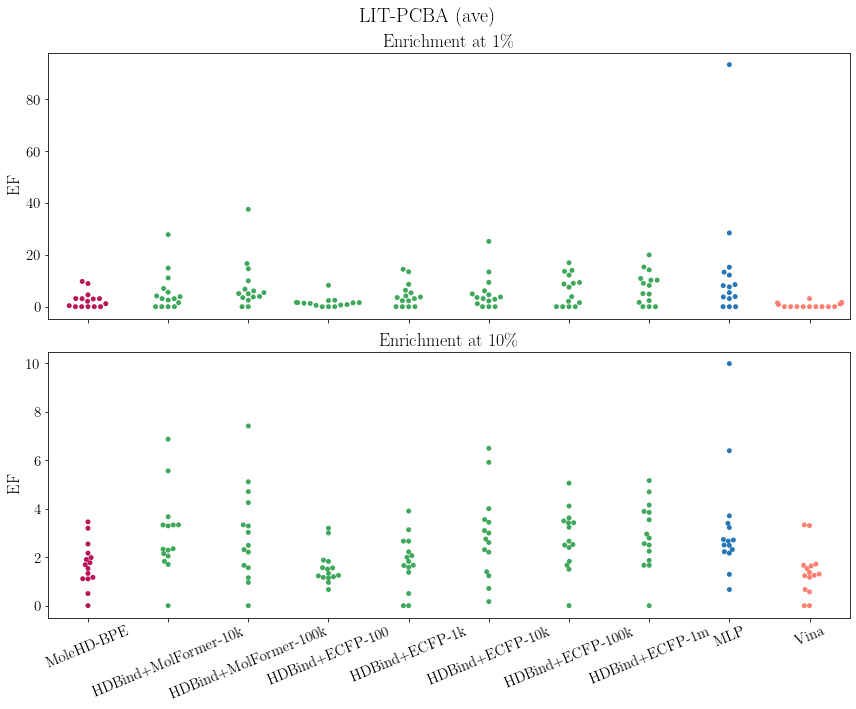

In [7]:
litpcba_df = compute_model_metric_df(dataset="lit-pcba", split="ave", target_list="all")

  0%|          | 0/15 [00:00<?, ?it/s]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PKM2-random.5.pkl
started with 246069 molecules for PKM2, after merging with available docking data, have 43394/61518 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
  7%|▋         | 1/15 [00:16<03:55, 16.82s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-GBA-random.5.pkl
started with 296218 molecules for GBA, after merging with available docking data, have 51851/74055 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 13%|█▎        | 2/15 [00:30<03:15, 15.03s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ago-random.5.pkl
started with 5596 molecules for ESR1_ago, after merging with available docking data, have 993/1399 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 20%|██        | 3/15 [00:31<01:42,  8.53s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MAPK1-random.5.pkl
started with 62937 molecules for MAPK1, after merging with available docking data, have 10739/15735 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 27%|██▋       | 4/15 [00:38<01:27,  7.99s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-VDR-random.5.pkl
started with 356272 molecules for VDR, after merging with available docking data, have 47208/66801 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 33%|███▎      | 5/15 [00:45<01:17,  7.74s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-KAT2A-random.5.pkl
started with 348742 molecules for KAT2A, after merging with available docking data, have 61615/87186 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 40%|████      | 6/15 [00:55<01:15,  8.42s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ALDH1-random.5.pkl
started with 145133 molecules for ALDH1, after merging with available docking data, have 19193/27213 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 47%|████▋     | 7/15 [01:04<01:09,  8.67s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-TP53-random.5.pkl
started with 4247 molecules for TP53, after merging with available docking data, have 764/1062 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 53%|█████▎    | 8/15 [01:05<00:42,  6.03s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PPARG-random.5.pkl
started with 5238 molecules for PPARG, after merging with available docking data, have 955/1310 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 60%|██████    | 9/15 [01:05<00:26,  4.41s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ADRB2-random.5.pkl
started with 312500 molecules for ADRB2, after merging with available docking data, have 54953/78125 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 67%|██████▋   | 10/15 [01:25<00:46,  9.22s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MTORC1-random.5.pkl
started with 33069 molecules for MTORC1, after merging with available docking data, have 6450/8268 in test set


/tmp/ipykernel_4138038/2535884398.py:88: DtypeWarning: Columns (12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  inactive_dock_scores = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), header=None)
/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 73%|███████▎  | 11/15 [01:28<00:29,  7.31s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-OPRK1-random.5.pkl
started with 269840 molecules for OPRK1, after merging with available docking data, have 47787/67460 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 80%|████████  | 12/15 [01:32<00:18,  6.21s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-IDH1-random.5.pkl
started with 362088 molecules for IDH1, after merging with available docking data, have 64088/90522 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 87%|████████▋ | 13/15 [02:09<00:31, 15.60s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ant-random.5.pkl
started with 5050 molecules for ESR1_ant, after merging with available docking data, have 886/1263 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 93%|█████████▎| 14/15 [02:10<00:11, 11.21s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-FEN1-random.5.pkl
started with 355771 molecules for FEN1, after merging with available docking data, have 62951/88943 in test set


/tmp/ipykernel_4138038/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ADRB2-random.5.pkl molehd-bpe
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_tr


  7%|▋         | 1/15 [00:21<04:57, 21.28s/it]

ALDH1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ALDH1-random.5.pkl molehd-bpe
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_tr


 13%|█▎        | 2/15 [00:27<02:45, 12.71s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ago-random.5.pkl molehd-bpe
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)



 20%|██        | 3/15 [00:28<01:24,  7.08s/it]

y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ant-random.5.pkl molehd-bpe
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: 


 27%|██▋       | 4/15 [00:28<00:48,  4.42s/it]

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-FEN1-random.5.pkl molehd-bpe
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)


 33%|███▎      | 5/15 [00:53<01:58, 11.84s/it]

GBA /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-GBA-random.5.pkl molehd-bpe
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: 


 40%|████      | 6/15 [01:14<02:12, 14.74s/it]

IDH1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-IDH1-random.5.pkl molehd-bpe
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true


 47%|████▋     | 7/15 [01:39<02:25, 18.19s/it]

KAT2A /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-KAT2A-random.5.pkl molehd-bpe
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_tr


 53%|█████▎    | 8/15 [02:03<02:20, 20.13s/it]

MAPK1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MAPK1-random.5.pkl molehd-bpe
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_tr


 60%|██████    | 9/15 [02:07<01:29, 14.98s/it]

y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
MTORC1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MTORC1-random.5.pkl molehd-bpe
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (


 67%|██████▋   | 10/15 [02:09<00:54, 10.92s/it]

y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
OPRK1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-OPRK1-random.5.pkl molehd-bpe
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (6


 73%|███████▎  | 11/15 [02:27<00:52, 13.13s/it]

PKM2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PKM2-random.5.pkl molehd-bpe
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true


 80%|████████  | 12/15 [02:43<00:42, 14.17s/it]

PPARG /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PPARG-random.5.pkl molehd-bpe
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)



 87%|████████▋ | 13/15 [02:44<00:19,  9.98s/it]

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-TP53-random.5.pkl molehd-bpe
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1


 93%|█████████▎| 14/15 [02:44<00:07,  7.06s/it]

y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-VDR-random.5.pkl molehd-bpe
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ADRB2-random.5.pkl hdbind-rp-molformer
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_scor


  7%|▋         | 1/15 [00:21<04:58, 21.33s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ALDH1-random.5.pkl hdbind-rp-molformer
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_scor


 13%|█▎        | 2/15 [00:28<02:45, 12.73s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-molformer
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)



 20%|██        | 3/15 [00:28<01:24,  7.07s/it]

y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-molformer
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (


 27%|██▋       | 4/15 [00:28<00:48,  4.40s/it]

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-FEN1-random.5.pkl hdbind-rp-molformer
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (8


 33%|███▎      | 5/15 [00:53<01:56, 11.65s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-GBA-random.5.pkl hdbind-rp-molformer
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (


 40%|████      | 6/15 [01:13<02:11, 14.63s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-IDH1-random.5.pkl hdbind-rp-molformer
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score:


 47%|████▋     | 7/15 [01:38<02:24, 18.01s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-KAT2A-random.5.pkl hdbind-rp-molformer
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_scor


 53%|█████▎    | 8/15 [02:02<02:19, 19.97s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MAPK1-random.5.pkl hdbind-rp-molformer
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_scor


 60%|██████    | 9/15 [02:06<01:29, 14.84s/it]

y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MTORC1-random.5.pkl hdbind-rp-molformer
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8


 67%|██████▋   | 10/15 [02:08<00:54, 10.81s/it]

y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-OPRK1-random.5.pkl hdbind-rp-molformer
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67


 73%|███████▎  | 11/15 [02:26<00:52, 13.02s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PKM2-random.5.pkl hdbind-rp-molformer
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score:


 80%|████████  | 12/15 [02:42<00:42, 14.04s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PPARG-random.5.pkl hdbind-rp-molformer
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)



 87%|████████▋ | 13/15 [02:42<00:19,  9.90s/it]

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-TP53-random.5.pkl hdbind-rp-molformer
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)


 93%|█████████▎| 14/15 [02:43<00:06,  6.99s/it]

y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-VDR-random.5.pkl hdbind-rp-molformer
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (668


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ADRB2-random.5.pkl hdbind-rp-molformer-100k
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125,


  7%|▋         | 1/15 [00:21<05:03, 21.67s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ALDH1-random.5.pkl hdbind-rp-molformer-100k
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213,


 13%|█▎        | 2/15 [00:28<02:48, 12.97s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-molformer-100k
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)



 20%|██        | 3/15 [00:29<01:27,  7.28s/it]

y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-molformer-100k
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)


 27%|██▋       | 4/15 [00:29<00:50,  4.59s/it]

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-FEN1-random.5.pkl hdbind-rp-molformer-100k
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943,


 33%|███▎      | 5/15 [00:54<01:59, 11.91s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-GBA-random.5.pkl hdbind-rp-molformer-100k
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	


 40%|████      | 6/15 [01:14<02:13, 14.84s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-IDH1-random.5.pkl hdbind-rp-molformer-100k
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1


 47%|████▋     | 7/15 [01:40<02:25, 18.23s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-KAT2A-random.5.pkl hdbind-rp-molformer-100k
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186,


 53%|█████▎    | 8/15 [02:04<02:21, 20.17s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-MAPK1-random.5.pkl hdbind-rp-molformer-100k
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735,


 60%|██████    | 9/15 [02:08<01:30, 15.05s/it]

MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-MTORC1-random.5.pkl hdbind-rp-molformer-100k
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_p


 67%|██████▋   | 10/15 [02:10<00:55, 11.00s/it]

y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-OPRK1-random.5.pkl hdbind-rp-molformer-100k
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_sco


 73%|███████▎  | 11/15 [02:28<00:52, 13.21s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-PKM2-random.5.pkl hdbind-rp-molformer-100k
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1


 80%|████████  | 12/15 [02:45<00:42, 14.26s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-PPARG-random.5.pkl hdbind-rp-molformer-100k
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pre


 87%|████████▋ | 13/15 [02:45<00:20, 10.08s/it]

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-TP53-random.5.pkl hdbind-rp-molformer-100k
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred:


 93%|█████████▎| 14/15 [02:45<00:07,  7.16s/it]

y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-VDR-random.5.pkl hdbind-rp-molformer-100k
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: 


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-ADRB2-random.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (7812


  7%|▋         | 1/15 [00:21<05:00, 21.44s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-ALDH1-random.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (2721


 13%|█▎        | 2/15 [00:28<02:45, 12.76s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)



 20%|██        | 3/15 [00:28<01:24,  7.08s/it]

y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)



 27%|██▋       | 4/15 [00:28<00:48,  4.41s/it]

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-FEN1-random.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)


 33%|███▎      | 5/15 [00:53<01:57, 11.79s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-GBA-random.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1


 40%|████      | 6/15 [01:14<02:12, 14.72s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-IDH1-random.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522,


 47%|████▋     | 7/15 [01:39<02:24, 18.12s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-KAT2A-random.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (8718


 53%|█████▎    | 8/15 [02:03<02:20, 20.09s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-MAPK1-random.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (1573


 60%|██████    | 9/15 [02:07<01:29, 14.96s/it]

y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-MTORC1-random.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1


 67%|██████▋   | 10/15 [02:08<00:54, 10.91s/it]

OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-OPRK1-random.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (6746


 73%|███████▎  | 11/15 [02:27<00:52, 13.17s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-PKM2-random.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518,


 80%|████████  | 12/15 [02:43<00:42, 14.18s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-PPARG-random.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)



 87%|████████▋ | 13/15 [02:44<00:19,  9.98s/it]

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-TP53-random.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)



 93%|█████████▎| 14/15 [02:44<00:07,  7.05s/it]

y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-VDR-random.5.pkl hdbind-rp-ecfp-1024-1-100
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-ADRB2-random.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125,


  7%|▋         | 1/15 [00:21<05:02, 21.63s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-ALDH1-random.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213,


 13%|█▎        | 2/15 [00:28<02:47, 12.88s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)



 20%|██        | 3/15 [00:28<01:25,  7.16s/it]

y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)


 27%|██▋       | 4/15 [00:29<00:49,  4.46s/it]

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-FEN1-random.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y


 33%|███▎      | 5/15 [00:53<01:57, 11.74s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-GBA-random.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	


 40%|████      | 6/15 [01:14<02:12, 14.70s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-IDH1-random.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1


 47%|████▋     | 7/15 [01:39<02:24, 18.10s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-KAT2A-random.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186,


 53%|█████▎    | 8/15 [02:03<02:20, 20.10s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-MAPK1-random.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735,


 60%|██████    | 9/15 [02:07<01:29, 14.97s/it]

y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-MTORC1-random.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)



 67%|██████▋   | 10/15 [02:09<00:54, 10.92s/it]

y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-OPRK1-random.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_


 73%|███████▎  | 11/15 [02:27<00:52, 13.18s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-PKM2-random.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1


 80%|████████  | 12/15 [02:44<00:42, 14.21s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-PPARG-random.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)



 87%|████████▋ | 13/15 [02:44<00:20, 10.01s/it]

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-TP53-random.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)



 93%|█████████▎| 14/15 [02:44<00:07,  7.07s/it]

y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-VDR-random.5.pkl hdbind-rp-ecfp-1024-1-1k
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_p


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ADRB2-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_


  7%|▋         | 1/15 [00:21<05:02, 21.59s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ALDH1-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_


 13%|█▎        | 2/15 [00:28<02:47, 12.85s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)



 20%|██        | 3/15 [00:28<01:25,  7.15s/it]

y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pre


 27%|██▋       | 4/15 [00:28<00:48,  4.45s/it]

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-FEN1-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (


 33%|███▎      | 5/15 [00:53<01:58, 11.83s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-GBA-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_scor


 40%|████      | 6/15 [01:14<02:12, 14.78s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-IDH1-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_sc


 47%|████▋     | 7/15 [01:39<02:25, 18.16s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-KAT2A-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_


 53%|█████▎    | 8/15 [02:04<02:21, 20.20s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MAPK1-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_


 60%|██████    | 9/15 [02:07<01:30, 15.06s/it]

y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MTORC1-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred


 67%|██████▋   | 10/15 [02:09<00:54, 10.97s/it]

y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-OPRK1-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_sco


 73%|███████▎  | 11/15 [02:28<00:52, 13.23s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PKM2-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_sc


 80%|████████  | 12/15 [02:44<00:42, 14.21s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PPARG-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)



 87%|████████▋ | 13/15 [02:44<00:20, 10.01s/it]

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-TP53-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062


 93%|█████████▎| 14/15 [02:45<00:07,  7.07s/it]

VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-VDR-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_scor


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ADRB2-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78


  7%|▋         | 1/15 [00:21<05:02, 21.61s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ALDH1-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27


 13%|█▎        | 2/15 [00:28<02:48, 12.97s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399


 20%|██        | 3/15 [00:29<01:27,  7.27s/it]


y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (126


 27%|██▋       | 4/15 [00:29<00:50,  4.58s/it]

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-FEN1-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: 


 33%|███▎      | 5/15 [00:54<01:57, 11.79s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-GBA-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055,


 40%|████      | 6/15 [01:14<02:12, 14.78s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-IDH1-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (9052


 47%|████▋     | 7/15 [01:39<02:24, 18.07s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-KAT2A-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87


 53%|█████▎    | 8/15 [02:04<02:21, 20.16s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-MAPK1-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15


 60%|██████    | 9/15 [02:07<01:30, 15.05s/it]

MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-MTORC1-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)


 67%|██████▋   | 10/15 [02:09<00:55, 11.01s/it]

OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-OPRK1-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67


 73%|███████▎  | 11/15 [02:28<00:53, 13.33s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-PKM2-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (6151


 80%|████████  | 12/15 [02:45<00:43, 14.34s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-PPARG-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)



 87%|████████▋ | 13/15 [02:45<00:20, 10.14s/it]

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-TP53-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_p


 93%|█████████▎| 14/15 [02:46<00:07,  7.20s/it]

y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-VDR-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score:


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-ADRB2-random.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125,


  7%|▋         | 1/15 [00:23<05:24, 23.18s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-ALDH1-random.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213,


 13%|█▎        | 2/15 [00:31<03:08, 14.48s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)



 20%|██        | 3/15 [00:33<01:45,  8.75s/it]

y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)


 27%|██▋       | 4/15 [00:35<01:07,  6.18s/it]

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-FEN1-random.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (889


 33%|███▎      | 5/15 [01:02<02:14, 13.44s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-GBA-random.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	


 40%|████      | 6/15 [01:23<02:26, 16.29s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-IDH1-random.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1


 47%|████▋     | 7/15 [01:50<02:37, 19.66s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-KAT2A-random.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186,


 53%|█████▎    | 8/15 [02:16<02:31, 21.68s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-MAPK1-random.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735,


 60%|██████    | 9/15 [02:22<01:39, 16.63s/it]

MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-MTORC1-random.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_p


 67%|██████▋   | 10/15 [02:25<01:02, 12.59s/it]

y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-OPRK1-random.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_


 73%|███████▎  | 11/15 [02:45<00:59, 14.75s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-PKM2-random.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1


 80%|████████  | 12/15 [03:03<00:47, 15.77s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-PPARG-random.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)



 87%|████████▋ | 13/15 [03:05<00:23, 11.60s/it]

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-TP53-random.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred:


 93%|█████████▎| 14/15 [03:07<00:08,  8.71s/it]

y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-VDR-random.5.pkl hdbind-rp-ecfp-1024-1-1m
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: 


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ADRB2-random.5.pkl mlp-1024-1
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_sco


  7%|▋         | 1/15 [01:37<22:48, 97.73s/it]

ALDH1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ALDH1-random.5.pkl mlp-1024-1
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_sco


 13%|█▎        | 2/15 [02:07<12:29, 57.67s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ago-random.5.pkl mlp-1024-1
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])


 20%|██        | 3/15 [02:08<06:22, 31.84s/it]

y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
ESR1_ant /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ant-random.5.pkl mlp-1024-1
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])


 27%|██▋       | 4/15 [02:09<03:35, 19.56s/it]

y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
FEN1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-FEN1-random.5.pkl mlp-1024-1
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.S


 33%|███▎      | 5/15 [04:02<08:54, 53.44s/it]

GBA /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-GBA-random.5.pkl mlp-1024-1
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: 


 40%|████      | 6/15 [05:48<10:42, 71.34s/it]

IDH1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-IDH1-random.5.pkl mlp-1024-1
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score


 47%|████▋     | 7/15 [07:44<11:27, 85.99s/it]

KAT2A /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-KAT2A-random.5.pkl mlp-1024-1
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_sco


 53%|█████▎    | 8/15 [10:10<12:14, 104.86s/it]

MAPK1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MAPK1-random.5.pkl mlp-1024-1
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_sco


 60%|██████    | 9/15 [10:26<07:42, 77.15s/it] 

MTORC1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MTORC1-random.5.pkl mlp-1024-1
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_t


 67%|██████▋   | 10/15 [10:34<04:38, 55.75s/it]

OPRK1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-OPRK1-random.5.pkl mlp-1024-1
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_sco


 73%|███████▎  | 11/15 [11:58<04:18, 64.53s/it]

PKM2 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PKM2-random.5.pkl mlp-1024-1
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score


 80%|████████  | 12/15 [13:12<03:22, 67.38s/it]

PPARG /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PPARG-random.5.pkl mlp-1024-1
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_tru


 87%|████████▋ | 13/15 [13:12<01:34, 47.08s/it]

y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
TP53 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-TP53-random.5.pkl mlp-1024-1
y_pred: torch.Size([1062])	y_score: torch.Size([1062, 2])	y_true: torch.Size([1062])
y_pred: torch.Size([1062])	y_score: torch.Size([1062, 2])	y_true: torch.Size([1062])
y_pred: torch.Size([1062])	y_score: torch.Size([1062, 2])	y_true:


 93%|█████████▎| 14/15 [13:13<00:33, 33.10s/it]

VDR /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-VDR-random.5.pkl mlp-1024-1
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: 


 90%|█████████ | 9/10 [39:24<06:45, 405.41s/it]
0it [00:00, ?it/s]
100%|██████████| 10/10 [39:24<00:00, 236.48s/it]


('Vina', 0.01)
           p     enrich
count  15.00  15.000000
mean    0.01   2.670534
std     0.00   6.290931
min     0.01   0.000000
25%     0.01   0.000000
50%     0.01   0.744817
75%     0.01   2.120516
max     0.01  24.825000
('Vina', 0.1)
                  p     enrich
count  1.500000e+01  15.000000
mean   1.000000e-01   1.601221
std    2.872975e-17   1.238805
min    1.000000e-01   0.000000
25%    1.000000e-01   1.110636
50%    1.000000e-01   1.362666
75%    1.000000e-01   1.885601
max    1.000000e-01   4.965000
('hdbind-rp-ecfp-1024-1', 0.01)
           p     enrich
count  15.00  15.000000
mean    0.01  25.051066
std     0.00  22.014785
min     0.01   0.000000
25%     0.01  10.412107
50%     0.01  21.722869
75%     0.01  28.723899
max     0.01  83.283951
('hdbind-rp-ecfp-1024-1', 0.1)
                  p     enrich
count  1.500000e+01  15.000000
mean   1.000000e-01   5.042508
std    2.872975e-17   2.378700
min    1.000000e-01   0.000000
25%    1.000000e-01   4.234516
50%    1.00

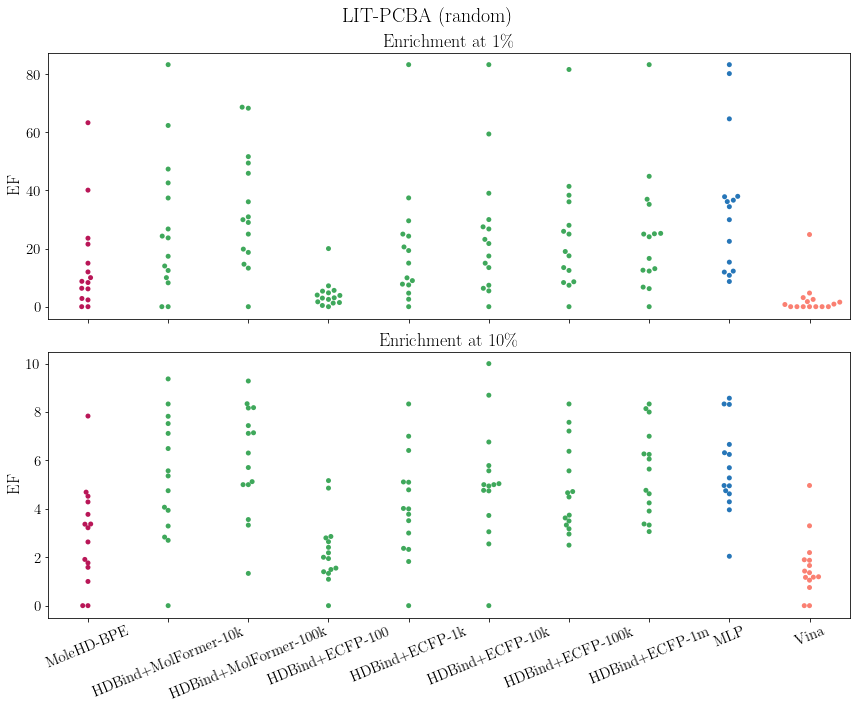

In [8]:
random_df = compute_model_metric_df(dataset="lit-pcba", split="random", target_list="all")